# Forberedelsen af data

In [74]:
#Libriaries & Models
import matplotlib
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.losses import MeanSquaredError


from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

import os
import pickle

import importlib
import src
importlib.reload(src)

Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Access the datasets

In [75]:
dataframes = src.dataset.load_dataframes()

Loaded from pickle


Data handling

In [76]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data(shuffle=False)

# Konverter til 3D-format for LSTM (samples, timesteps, features)
# Her antages en enkelt timestep, men du kan øge det, hvis du vil have flere tidssteg
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Loaded from pickle


# LSTM - RBF Model





In [77]:
num_centers = 30
sigma = 1.0
lstm_nodes = 5

# Brugerdefineret RBF-lag i Keras
class RBFLayer(Layer):
    def __init__(self, num_centers, sigma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.num_centers = num_centers
        self.sigma = sigma

    def build(self, input_shape):
        # Generér centre tilfældigt ved initialisering
        self.centers = self.add_weight(
            shape=(self.num_centers, input_shape[-1]),
            initializer="random_normal",
            trainable=True,
            name="centers"
        )

    def call(self, inputs):
        # Beregn euklidisk afstand fra input til centre
        inputs_expanded = tf.expand_dims(inputs, 1)  # (batch, 1, features)
        centers_expanded = tf.expand_dims(self.centers, 0)  # (1, num_centers, features)

        # Beregn euklidisk afstand
        distances = tf.reduce_sum(tf.square(inputs_expanded - centers_expanded), axis=-1)
        return tf.exp(-distances / (2 * tf.square(self.sigma)))

model = Sequential([
    RBFLayer(num_centers=num_centers, sigma=sigma, input_shape=(1, X_train.shape[-1])),
    LSTM(lstm_nodes, activation='tanh', return_sequences=False),  # LSTM lag
    Dense(y_train.shape[1])  # Output lag for Mz1, Mz2, Mz3
])

model.compile(optimizer='adam', loss='mse')

/var/folders/_4/qbt6rn_s3_7gh2mhy42959c80000gn/T/ipykernel_35630/1143035431.py:8: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


# Training the model

In [78]:
batchsize = 128
epochs = 7

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=0.2, verbose=1)

# Forudsig output for testdata
y_pred = model.predict(X_test)


# Omvend normalisering af y_pred og y_test
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# Beregn MSE
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, y_pred).numpy()
print("Mean Squared Error of test data:", mse_value)

# mse = MeanSquaredError(y_test, y_pred)
# print("Mean Squared Error på testdata:", mse)

Epoch 1/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0129 - val_loss: 0.0036
Epoch 2/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 3/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 4/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 6/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 7/7
8001/8001 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0030 - val_loss: 0.0033
10001/10001 ━━━━━━━━━━━━━━━━━━━━ 9s 906us/step
Mean Squared Error of test data: 228.52579


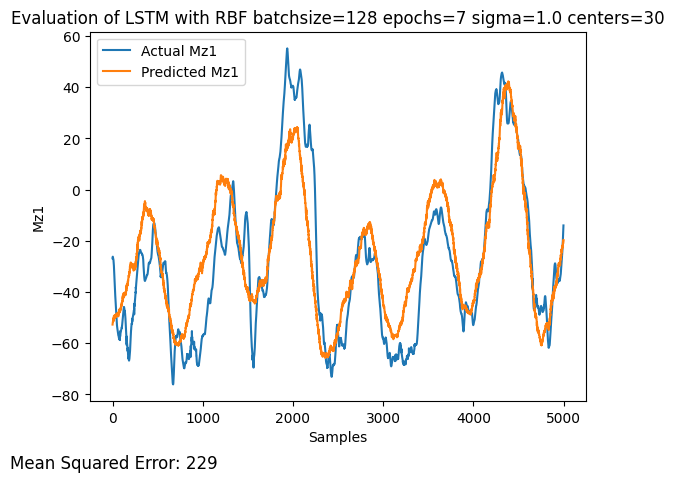

In [79]:
src.plots.evaluate_predictions(y_pred[:, 0][:5000], y_test[:, 0][:5000], mse(y_test, y_pred).numpy(), name=f"LSTM with RBF batchsize={batchsize} epochs={epochs} sigma={sigma} centers={num_centers}")

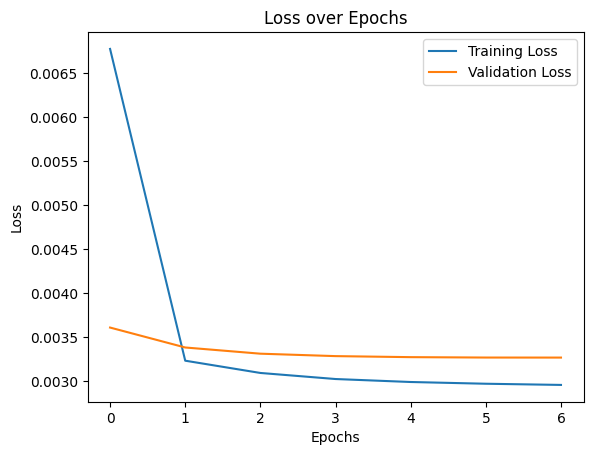

In [80]:
# Extract loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()